# Deforestation Monitoring using Sentinel 2 and xarray

Sentinel 2 data is one of the most popular satellite datasets, but it does come with challenges. Cloud-free mosaics have to be constructed often in order to get analysis-ready data. Accessing a lot of data through tiles takes a long time, and getting the data into a format it can be easily analysed in with common Python tools can be a challenge.

In this notebook, we will show how this whole process of getting analysis-ready data into Python can be sped up by using the Copernicus Dataspace Ecosystem and Sentinel Hub APIs. This is being presented by running through a basic deforestation monitoring use-case. The notebook uses the popular [xarray](https://docs.xarray.dev/en/stable/index.html#) Python library to handle the multidimensional data.

What we show in this notebook:

- How to access Sentinel 2 data in the Copernicus Dataspace Ecosystem
- Calculation of NDVI in the Cloud
- Monthly composites
- Creating a time series
- Loading data into xarray
- Basic classification using thresholding
- Accuracy assessment of classification


## Prerequisites

- [A Copernicus Dataspace Ecosystem account](https://documentation.dataspace.copernicus.eu/Registration.html)
- Basic understanding of the Sentinel Hub Processing API ([Introductory Notebook available here](https://documentation.dataspace.copernicus.eu/notebook-samples/sentinelhub/data_download_process_request.html))

In [1]:
import getpass
from datetime import datetime
from pathlib import Path

import requests
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from ipyleaflet import GeoJSON, Map, basemaps
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SHConfig,
)
from sklearn.metrics import accuracy_score

### Credentials

To obtain your `client_id` & `client_secret`, you need to navigate to your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings, you can create a new OAuth client to generate these credentials. More detailed instructions can be found on the corresponding [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Following these instructions, you can create a profile specifically for using the package to access Copernicus Data Space Ecosystem data collections. This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite/change the default profile every time you run or write a new Jupyter Notebook. 

If you are using the Sentinel Hub Python package for the Copernicus Data Space Ecosystem for the first time, you should create a profile specifically for the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `profile_name`.

In [2]:
# config = SHConfig("profile-name")

## Area of Interest

First, we define an area of interest. In this case the area of interest is in the Harz Mountains in Germany since we are aware of substantial forest dieback in recent years.

The resolution is defined in the units of the coordinate reference system. Because we want to define units in meters, we also need to define the bounding box coordinates in a CRS using meters. We use EPSG:3035 in this case. This CRS is only available for Europe, outside of Europe we could use EPSG:3857 or UTM Zones.

You can also explore the area of interest in the Copernicus Browser [here](https://link.dataspace.copernicus.eu/5t1).

![Deforestation in Harz Mountain as seen from Sentinel-2, June 2023](./img/deforestation_thumbnail.jpg)

In [3]:
# Desired resolution of our data
resolution = (100, 100)
bbox_coords = [10.633501, 51.611195, 10.787234, 51.698098]
epsg = 3035
# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)

In [ ]:
x, y = bbox.transform(4326).middle

# Add OSM background
overview_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(y, x), zoom=10)

# Add geojson data
geo_json = GeoJSON(data=bbox.transform(4326).geojson)
overview_map.add_layer(geo_json)

# Display
overview_map

## Data Access

Next, we define our [evalscript](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html). The evalscript is a piece of JavaScript code that tells the Copernicus Dataspace Ecosystem how to process the pixels you request before they are delivered to you.

This makes it a very powerful tool to perform pixel-based calculations in the cloud. For inspiration on what can be done in an evalscript, there is an extensive online resource of community-created evalscripts called [custom-scripts](https://custom-scripts.sentinel-hub.com/). In this example, we want to calculate cloud-free mosaics. This is a perfect application for an evalscript, as you do not have to download the data needed to generate the mosaic, but all calculations are done on the server and only the final cloud-free mosaic is delivered. 

So let's go over how this is done.

The evalscript needs to define two functions, `setup()` and `evaluatePixel()`. First, let's look at the setup function:

```js
function setup() {
    return {
        input: ["B08", "B04", "B03", "B02", "SCL"],
        output: {
            bands: 5,
            sampleType: "INT16"
        },
        mosaicking: "ORBIT"
    }
}
```

Here we specify which bands we want to request. In this case, we get the bands needed to calculate the NDVI and to display a True Color Image. We also define how our output should be structured, and define the output as a 5-band image with the INT16 data type. 

Finally, we specify the mosaicking parameter. This determines how the pixel values are returned to us.
- `mosaicking: "SIMPLE"` returns only a single pixel, either from the most recent, the least recent or the least cloudy Sentinel 2 tile.

- `mosaicking: "ORBIT"` returns all pixels of unique orbits for the entire time series as a list. We use this to obtain all possible values from which we can create the cloud-free mosaic.

Next let's take a look at the `evaluatePixel()` function. This is the function where the actual calculation is defined:

```js
function evaluatePixel(samples) {
    var valid = samples.filter(validate);
    if (valid.length > 0 ) {
        let cloudless = {
            b08: getFirstQuartileValue(valid.map(s => s.B08)),
            b04: getFirstQuartileValue(valid.map(s => s.B04)),
            b03: getFirstQuartileValue(valid.map(s => s.B03)),
            b02: getFirstQuartileValue(valid.map(s => s.B02)),
        }
        let ndvi = ((cloudless.b08 - cloudless.b04) / (cloudless.b08 + cloudless.b04))
        // This applies a scale factor so the data can be saved as an int
        let scale = [cloudless.b04, cloudless.b03, cloudless.b02, ndvi].map(v => v*10000);
        return scale
    }
    // If there isn't enough data, return NODATA
    return [-32768, -32768, -32768, -32768]
}
```

The way we construct the cloud free mosaic is by first filtering all the available acquisitions to only include the ones which contain clear data with `samples.filter(validate);`. Then we sort the array and get the value at the first quartile of the array. Getting the first quartile instead of the mean or median further reduces the risk that we select a cloudy pixel.

Finally, we calculate the NDVI using the cloud-free values and return all the desired values as an array.

In [4]:
evalscript_cloudless = """
//VERSION=3
function setup() {
    return {
        input: ["B08", "B04", "B03", "B02", "SCL"],
        output: {
            bands: 4,
            sampleType: "INT16"
        },
        mosaicking: "ORBIT"
    }
}

function getFirstQuartileValue(values) {
    values.sort((a,b) => a-b);
    return getFirstQuartile(values);
}

function getFirstQuartile(sortedValues) {
    var index = Math.floor(sortedValues.length / 4);
    return sortedValues[index];
}

function validate(sample) {
    // Define codes as invalid:
    const invalid = [
        0, // NO_DATA
        1, // SATURATED_DEFECTIVE
        3, // CLOUD_SHADOW
        7, // CLOUD_LOW_PROBA
        8, // CLOUD_MEDIUM_PROBA
        9, // CLOUD_HIGH_PROBA
        10 // THIN_CIRRUS
    ]
    return !invalid.includes(sample.SCL)
}

function evaluatePixel(samples) {
    var valid = samples.filter(validate);
    if (valid.length > 0 ) {
        let cloudless = {
            b08: getFirstQuartileValue(valid.map(s => s.B08)),
            b04: getFirstQuartileValue(valid.map(s => s.B04)),
            b03: getFirstQuartileValue(valid.map(s => s.B03)),
            b02: getFirstQuartileValue(valid.map(s => s.B02)),
        }
        let ndvi = ((cloudless.b08 - cloudless.b04) / (cloudless.b08 + cloudless.b04))
        // This applies a scale factor so the data can be saved as an int
        let scale = [cloudless.b04, cloudless.b03, cloudless.b02, ndvi].map(v => v*10000);
        return scale
    }
    // If there isn't enough data, return NODATA
    return [-32768, -32768, -32768, -32768]
}
"""

We have defined how the pixels should be handled. However, we still need to define some other parameters to get a full request. 

We need to define which data we want to use and the timeframe of the data.

This is what we are doing in the next cell. Here, we also start building our time series. To see changes over the years, we want to get cloud-free mosaics for the same 3 months over the years. We do this by defining the three months (June-August) in the `interval_of_interest()` function. Then we define a function `get_request()`, which will build the request to the Sentinel Hub API on the Copernicus Data Space Ecosystem.

In this [`SentinelHubRequest`](https://sentinelhub-py.readthedocs.io/en/latest/reference/sentinelhub.api.process.html#sentinelhub.api.process.SentinelHubRequest), we define the input data, the timeframe, the output type (TIFF), the bounding box, the resolution and where to save the data.

We define this as a function because we want to make several requests with the changing years being the only input.

In [5]:
def interval_of_interest(year):
    return (datetime(year, 6, 1), datetime(year, 9, 1))


def get_request(year):
    time_interval = interval_of_interest(year)
    return SentinelHubRequest(
        evalscript=evalscript_cloudless,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    "s2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        resolution=resolution,
        config=config,
        data_folder="./data",
    )

This cell now creates a request for each of the years, from 2018 to 2023.

In [6]:
# create a dictionary of requests
sh_requests = {}
for year in range(2018, 2024):
    sh_requests[year] = get_request(year)

sh_requests

{2018: <sentinelhub.api.process.SentinelHubRequest at 0x217d27aa4d0>,
 2019: <sentinelhub.api.process.SentinelHubRequest at 0x217d2951dd0>,
 2020: <sentinelhub.api.process.SentinelHubRequest at 0x217d29520d0>,
 2021: <sentinelhub.api.process.SentinelHubRequest at 0x217d29523d0>,
 2022: <sentinelhub.api.process.SentinelHubRequest at 0x217d29526d0>,
 2023: <sentinelhub.api.process.SentinelHubRequest at 0x217d2952c90>}

The next step is to download the data. This is done with the utility function `SentinelHubDownloadClient`. It downloads a list of requests in parallel, greatly improving the download speed. Before we can do that, we need to change the format of the requests slightly, which is done in the variable `list_of_requests`.

In [8]:
list_of_requests = [request.download_list[0] for request in sh_requests.values()]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)

The output of the requests do not provide any information about which year the data is from, so we rename the output of each request to the year of the data it represents.

In [9]:
def request_output_path(request):
    # Gets the full path to the output from a request
    return Path(request.data_folder, request.get_filename_list()[0])


# Moves and renames the files to the root directory of results
for year, request in sh_requests.items():
    request_output_path(request).rename(f"./data/{year}.tif")

## Read data with xarray

Now we can load the data into [xarray](https://docs.xarray.dev/en/stable/). We use [rioxarray](https://corteva.github.io/rioxarray/html/index.html), an extension for xarray, to load multiple tiffs into a single xarray dataset.
xarray is a scalable tool for analysing multidimensional data in Python. This makes xarray ideal for analysing time series data.

The different files correspond to the time dimension, but xarray does not know which file is which time step. Therefore, we add a pre-processing step in which we parse out the year from the filename and add it as the time dimension for that file. 

The warnings in the output can be safely ignored.

In [10]:
def add_time_dim(xda):
    # This pre-processes the file to add the correct
    # year from the filename as the time dimension
    year = int(Path(xda.encoding["source"]).stem)
    return xda.expand_dims(year=[year])

In [11]:
tiff_paths = Path("./data").glob("*.tif")
ds_s2 = xr.open_mfdataset(
    tiff_paths,
    engine="rasterio",
    preprocess=add_time_dim,
    band_as_variable=True,
)
ds_s2 = ds_s2.rename(
    {
        "band_1": "R",
        "band_2": "G",
        "band_3": "B",
        "band_4": "NDVI",
    }
)
ds_s2 = ds_s2 / 10000

We can use the resultatnt xarray to plot the RGB data as a true color image:

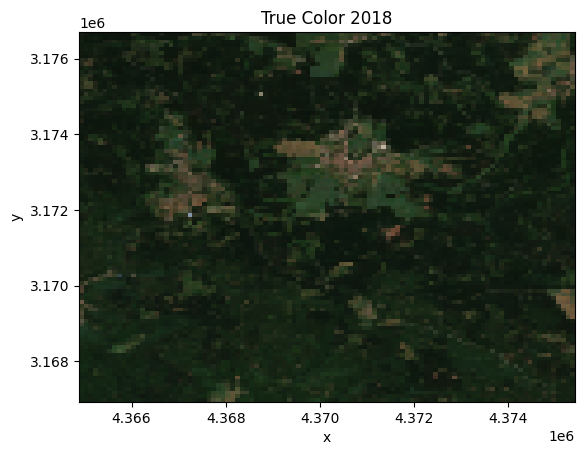

In [13]:
# Get RGB data for a year
plot_year = 2018
true_color = ds_s2.sel(year=plot_year)[["R", "G", "B"]].to_array()
# Divide by scale factor and apply gamma to brighten image
(true_color * 4).plot.imshow()
plt.title(f"True Color {plot_year}");

We now have an xarray dataset with 3 coordinates: year, x and y, as well as the data variables returned by the evalscript as data variables in the dataset.

In [12]:
ds_s2

<xarray.Dataset>
Dimensions:      (year: 6, x: 105, y: 98)
Coordinates:
  * year         (year) int64 2018 2019 2020 2021 2022 2023
  * x            (x) float64 4.365e+06 4.365e+06 ... 4.375e+06 4.375e+06
  * y            (y) float64 3.177e+06 3.177e+06 ... 3.167e+06 3.167e+06
    spatial_ref  int32 0
Data variables:
    R            (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    G            (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    B            (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    NDVI         (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

We can also similarly plot the NDVI values:

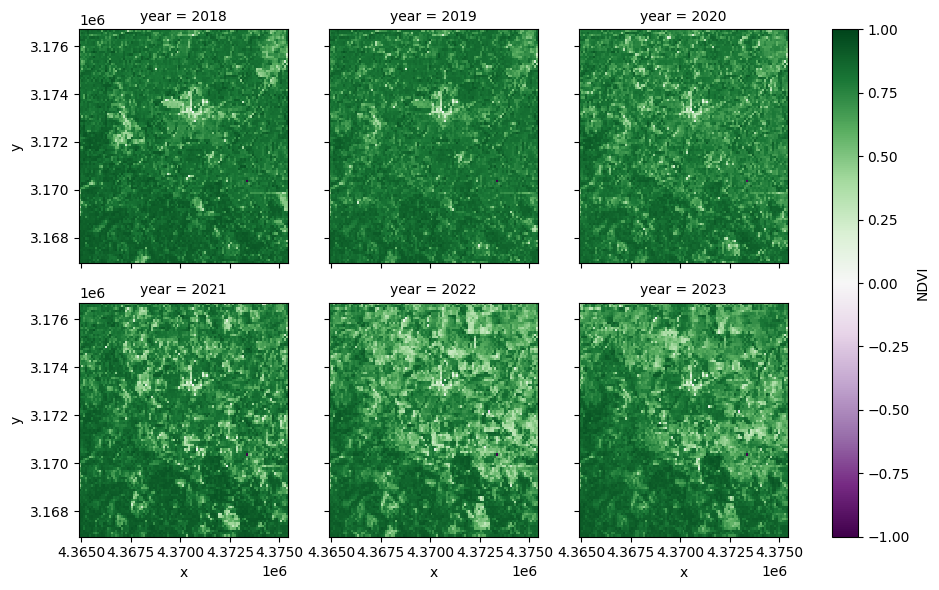

In [14]:
ds_s2.NDVI.plot(cmap="PRGn", x="x", y="y", col="year", col_wrap=3);

## Analysis

For analysis the first step is to classify pixels as forest. In our case we will just do a simple thresholding classification where we classify everything above a certain threshold as forest. This isn't the best approach for classifying forest, since agricultural areas can also easily reach very high NDVI values. A better approach would be to classify based on the temporal signature of the pixel. 

However, for this basic analysis, we stick to the simple thresholding approach.

In this case we classify everything above an NDVI of 0.7 as forest. This calculated forest mask is then saved to a new Data Variable in the xarray dataset: 

In [15]:
ds_s2["FOREST"] = ds_s2.NDVI > 0.7

With this forest mask we can already do a quick preliminary analysis to plot the total forest area over the years.

To do this we sum up the pixels along the x and y coordinate but not along the time coordinate. This will leave us with one value per year representing the number of pixels classified as forest. We can then calculate the forest area by multiplying the number of forest pixels by the resolution.

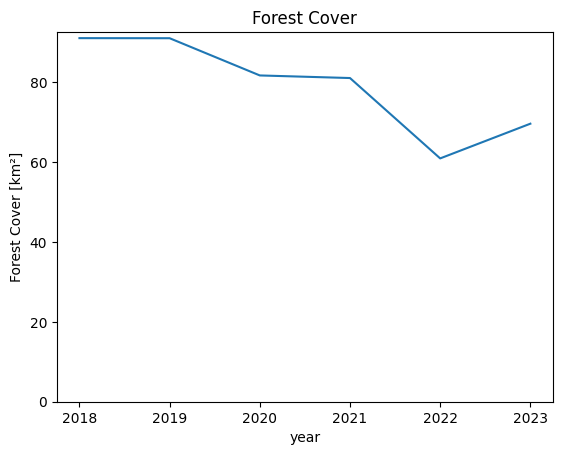

In [16]:
def to_km2(dataarray, resolution):
    # Calculate forest area
    return dataarray * np.prod(list(resolution)) / 1e6


forest_pixels = ds_s2.FOREST.sum(["x", "y"])
forest_area_km2 = to_km2(forest_pixels, resolution)
forest_area_km2.plot()
plt.title("Forest Cover")
plt.ylabel("Forest Cover [km²]")
plt.ylim(0);

We can see that the total forest area in this AOI decreased from around 80 km² in 2018 to only around 50 km² in 2023.

The next step is to make change maps from year to year. To do this we basically take the difference of the forest mask of a year with its previous year.

This will result in 0 value where there has been no change, -1 where forest was lost and +1 where forest was gained.

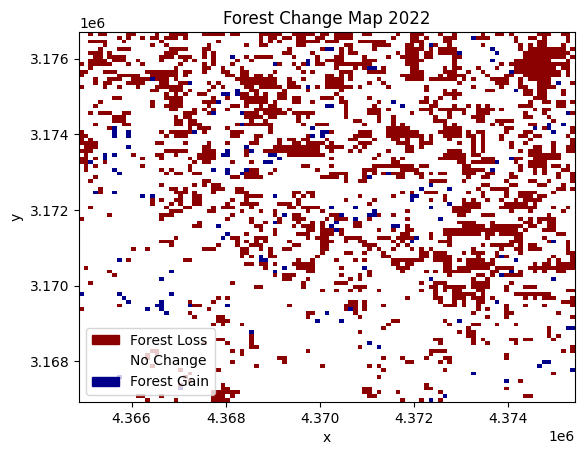

In [17]:
# Make change maps of forest loss and forest gain compared to previous year

# 0 - 0 = No Change: 0
# 1 - 1 = No Change: 0
# 1 - 0 = Forest Gain: 1
# 0 - 1 = Forest Loss: -1

# Define custom colors and labels
colors = ["darkred", "white", "darkblue"]
labels = ["Forest Loss", "No Change", "Forest Gain"]

# Create a colormap and normalize it
cmap = mcolors.ListedColormap(colors)
norm = plt.Normalize(-1, 1)  # Adjust the range based on your data

plot_year = 2022
ds_s2["CHANGE"] = ds_s2.FOREST.astype(int).diff("year", label="upper")
ds_s2.CHANGE.sel(year=plot_year).plot(cmap=cmap, norm=norm, add_colorbar=False)

# Create a legend with string labels
legend_patches = [
    mpatches.Patch(color=color, label=label) for color, label in zip(colors, labels)
]
plt.legend(handles=legend_patches, loc="lower left")
plt.title(f"Forest Change Map {plot_year}");

Here, we can see the spatial distribution of areas affected by forest loss. In the displayed change from 2021 to 2022, most of the forest loss happened in the northern part of the study area, while the southern part lost comparatively less forest.

To get a feel for the loss per year, we can cumulatively sum up the lost areas over the years. This should basically follow the same trends as the earlier plot of total forest area. 

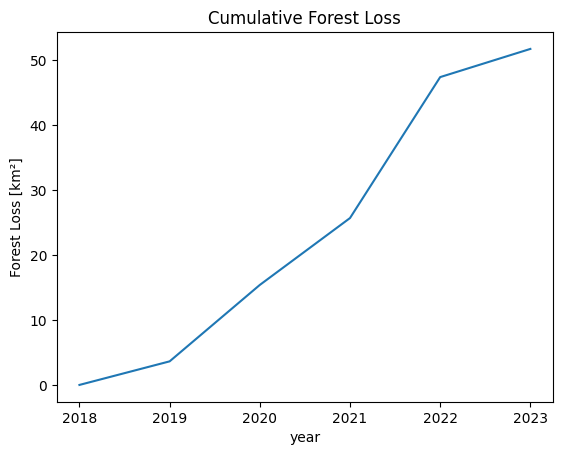

In [18]:
# Forest Loss per Year
forest_loss = (ds_s2.CHANGE == -1).sum(["x", "y"])
forest_loss_km2 = to_km2(forest_loss, resolution)
forest_loss_km2.cumsum().plot()
plt.title("Cumulative Forest Loss")
plt.ylabel("Forest Loss [km²]");

We can see that there have been two years with particularly large amounts of lost forest area. From 2019-2020 and with by far the most lost area between 2021 and 2022.

## Validation

Finally, we want to see how accurate our data is compared to the widely used Hansen Global Forest Change data. In a real scientific scenario, we would use Ground Truth data to assess the accuracy of our classification. In this case we use the Global Forest Change data in place of Ground Truth data, just to show how an accuracy assessment can be done. The assessment we are doing only shows how accurately we replicate the Global Forest Change data, however we will not know if our product is more or less accurate. For a more accurate assessment, actual Ground Truth data is required.

First we download the Global Forest Change Data [here](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/download.html) and open it using xarray.

In [19]:
data_path = Path("./data/")
data_path.mkdir(parents=True, exist_ok=True)
hansen_filename = "Hansen_GFC-2022-v1.10_lossyear_60N_010E.tif"
comp_data = data_path / hansen_filename

with comp_data.open("wb") as fs:
    hansen_data = requests.get(
        f"https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/{hansen_filename}"
    )
    fs.write(hansen_data.content)

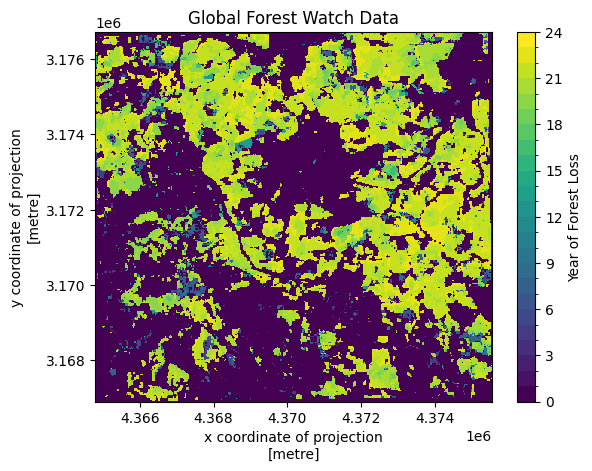

In [20]:
# Open the file
ground_truth = (
    xr.open_dataarray(comp_data, engine="rasterio")
    .rio.clip_box(*bbox_coords)
    .rio.reproject(epsg)
    .sel(band=1)
    .where(lambda gt: gt < 100, 0)  # fill no-data (values over 100) with 0
)
ground_truth.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch Data");

The data shows in which year forest was first lost. To compare with our own data, we need to add the data to our dataset. To do this the data needs to have the same coordinates. This can be achieved with `.interp_like()`. This function interpolates the data to match up the coordinates of another dataset.

In this case we chose the interpolation method `nearest` since it is categorical data.

In [21]:
ds_s2["GROUND_TRUTH"] = ground_truth.interp_like(ds_s2, method="nearest").astype(int)
ds_s2

<xarray.Dataset>
Dimensions:       (year: 6, x: 105, y: 98)
Coordinates:
  * year          (year) int64 2018 2019 2020 2021 2022 2023
  * x             (x) float64 4.365e+06 4.365e+06 ... 4.375e+06 4.375e+06
  * y             (y) float64 3.177e+06 3.177e+06 ... 3.167e+06 3.167e+06
    spatial_ref   int32 0
    band          int32 1
Data variables:
    R             (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    G             (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    B             (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    NDVI          (year, y, x) float32 dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    FOREST        (year, y, x) bool dask.array<chunksize=(1, 9, 105), meta=np.ndarray>
    CHANGE        (year, y, x) float64 dask.array<chunksize=(2, 9, 105), meta=np.ndarray>
    GROUND_TRUTH  (y, x) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

The ground truth data saves the year when deforestation was first detected for a pixel in a single raster. To do this, it encodes the year of forest loss as an integer, giving the year. So, an integer 21 means the pixel was first detected as deforested in 2021, whereas a value of 0 means that deforestation was never detected.

Currently our classification saves the deforestation detection in multiple rasters, one for each year. To get our data into a format that is similar to our comparison data we need to convert our rasters for each time step into a single one.

To do this we first assign all pixels which were detected as deforestation (`CHANGE == -1`) to the year in which the deforestation was detected (`lost_year`). Then we compute over our time-series the first occurence of deforestation (equivalent to the first non-zero value) per pixel. This is then saved in a new data variable.

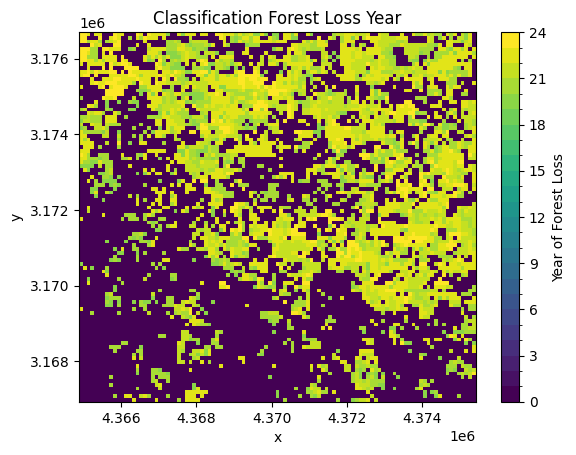

In [22]:
# convert lost forest (-1) into the year it was lost
lost_year = (ds_s2.CHANGE == -1) * ds_s2.year % 100
first_nonzero = (lost_year != 0).argmax(axis=0).compute()
ds_s2["LOST_YEAR"] = lost_year[first_nonzero]
ds_s2.LOST_YEAR.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Classification Forest Loss Year");

Comparing this visually to the Global Forest Watch data, allows us to do some initial quality assessment. We can see definite differences between the two datasets. The Global Forest Watch data has much more clearly defined borders. In general, our classification seems to overestimate deforestation. However, the general pattern of forest loss is the same in both. Most of the deforestation is in the north of the study area, with less forest loss in the south.

There are a few reasons for those differences. The main difference has to be in our much more simple approach to forest classification and change detection. It is expected that our approach will lead to large amounts of commission errors since changes are only confirmed using a single observation. It however can also lead to a lot of omission errors since the NDVI thresholding might classify highly productive non-forest areas as forest due to their high NDVI values. 

However, there are also some systematic differences. Our algorithm looks at differences between the middle of the years, which means that some changes can happen at the end of the growing year which will be detected first in the next year whereas the Global Forest Watch dataset will detect it in the correct (earlier) year.

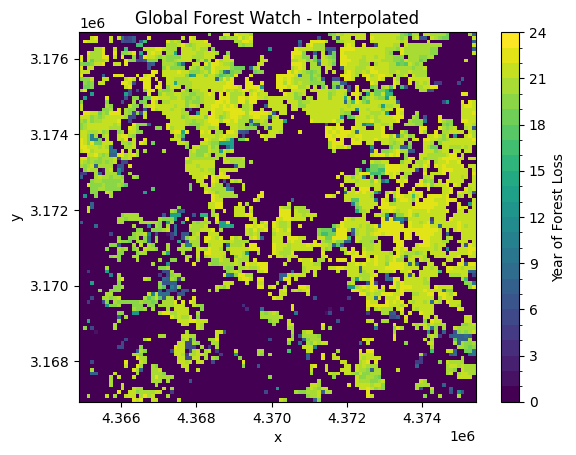

In [23]:
ds_s2.GROUND_TRUTH.plot(levels=range(25), cbar_kwargs={"label": "Year of Forest Loss"})
plt.title("Global Forest Watch - Interpolated");

Finally, we can also calculate an accuracy score. This is a score from 0-1, where values close to 0.5 basically mean that the classification is random, and values close to 1 mean that most of the values of our comparison data and classification data match.

First, we look at the overall accuracy of forest loss over the entire period from 2018 to 2023.

In [24]:
score = accuracy_score(
    (ds_s2.LOST_YEAR > 18).values.ravel(), (ds_s2.GROUND_TRUTH > 18).values.ravel()
)
print(f"The overall accuracy of forest loss detection is {score:.2f}.")

The overall accuracy of forest loss detection is 0.77.


As expected from the visual interpretation, with an accuracy of 0.77, our product differs quite a lot compared to the Global Forest Watch data. From this we do not know for sure that our product is less accurate compared to the actual forest loss patterns observed on the ground. We only know that it is different to the Global Forest Watch product. It might be more or less accurate. 

However, because of the simplicity of our algorithm, it is safe to assume that our output is less accurate. 

## Summary

This notebook showed how to efficiently access data stored on the Copernicus Dataspace Ecosystem using the Sentinel Hub APIs. This includes generating cloud-free mosaics and calculating spectral indices in the cloud. 

It also showed how to import this data using xarray and carry out a basic multi-temporal detection of forest loss.

This notebook should serve as a starting point for your own analysis using the powerful Python Data Analysis ecosystem and leveraging the Copernicus Data Space Ecosystem APIs for quick satellite data access.